In [19]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.integrate import quad

from time import perf_counter as time

from tqdm import tqdm
from scipy import linalg, stats

from scipy.special import jacobi, legendre, roots_jacobi, eval_jacobi, factorial, gamma

# from tb_utils import JacobiGL, constructV, constructVx, constructD, z2x, z2x_dz, x2z, x2z_dx, evaluate_jacobi_grid, constructMinv, jacobi_p_normalisation_const
from tb_utils import *
import itertools
from scipy.sparse import diags, kron, eye, spdiags

from scipy.integrate import solve_ivp

import warnings
warnings.filterwarnings('ignore')

## 2c-g) KdV equation

In [146]:
c = 1
x0 = 0
alpha = 15

def f_exact(x, c=c, x0=x0): return (c/2)*(1/np.cosh((1/2)*np.sqrt(c)*(x - x0)))**2
def u_exact(x, t): return f_exact(x - c*t)

def u_exact_z(z_2pi, t):
    x = (alpha/np.pi) * z_2pi - alpha
    return u_exact(x, t)

N_plot = 1000
t_linspace = np.linspace(0, 10, N_plot)
x_linspace = np.linspace(-10, 10, N_plot)
X, T = np.meshgrid(x_linspace, t_linspace)
U_exact = u_exact(X, T)

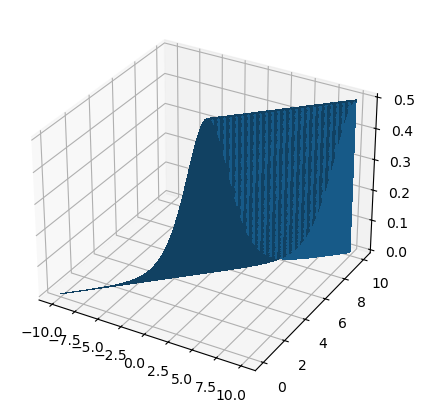

In [3]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), subplot_kw={"projection": "3d"})
ax.plot_surface(x_linspace, t_linspace, U_exact, linewidth=0, antialiased=False, label = "Exact Solution")

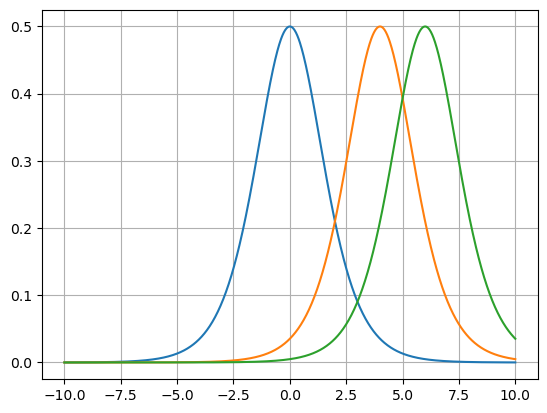

In [4]:
plt.plot(x_linspace, u_exact(x_linspace, 0), label = "t = 0")
plt.plot(x_linspace, u_exact(x_linspace, 4), label = "t = 0")
plt.plot(x_linspace, u_exact(x_linspace, 6), label = "t = 0");
plt.grid();

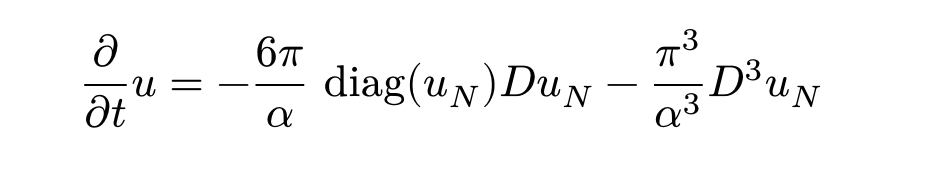

In [147]:
# just RK4 for the temporal part
N = 50
deriv_const = np.pi/alpha
rtol = 1e-5
atol = 1e-5
t0, tf = 0, 3

def method_of_lines_KdV(N, t0, tf, deriv_const, rtol, atol):

    D = get_D(N_input = N)

    def F(t, z, D = D, deriv_const = deriv_const):
        return (-6*deriv_const)*np.diag(z) @ D @ z - (deriv_const)**3 * D @ D @ D @ z

    z_2pi = np.linspace(0, 2*np.pi, N)
    z0 = u_exact_z(z_2pi, t=0)

    result_scipy = solve_ivp(
        F,
        [t0, tf],
        y0 = z0,
        method="RK45",
        rtol=rtol,
        atol=atol,
    )

    return result_scipy.t, result_scipy.y.T, z_2pi

N = 50
t_tmp, U_hat, z_2pi = method_of_lines_KdV(N, t0, tf, deriv_const, rtol, atol)
result_scipy

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.382e-02 ...  2.999e+00  3.000e+00]
        y: [[ 9.079e-05  1.006e-04 ...  1.120e-03  2.939e-03]
            [ 1.365e-04  1.309e-04 ...  3.900e-03  2.117e-03]
            ...
            [ 1.365e-04  1.314e-04 ...  2.217e-03  4.006e-03]
            [ 9.079e-05  8.692e-05 ...  2.998e-03  1.191e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 5300
     njev: 0
      nlu: 0

(219, 50) (219, 50)
0.10766327692889864


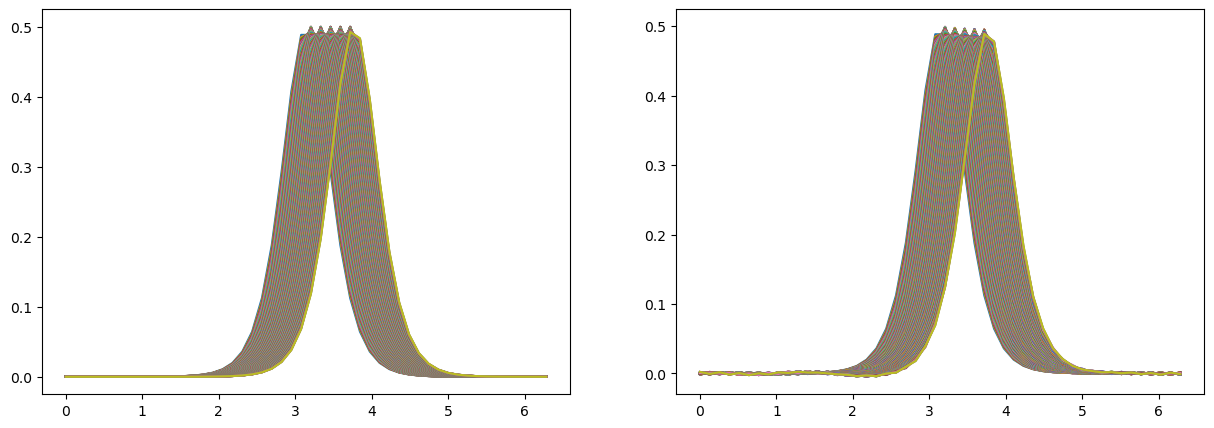

In [148]:
X_full_ivp, T_full_ivp = np.meshgrid(z_2pi, t_tmp)
U_full = u_exact_z(X_full_ivp, T_full_ivp)
print(U_full.shape, U_hat.shape)

E = U_full - U_hat
print(np.linalg.norm(E, ord=np.inf))
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(z_2pi, U_full.T);
ax[1].plot(z_2pi, U_hat.T);

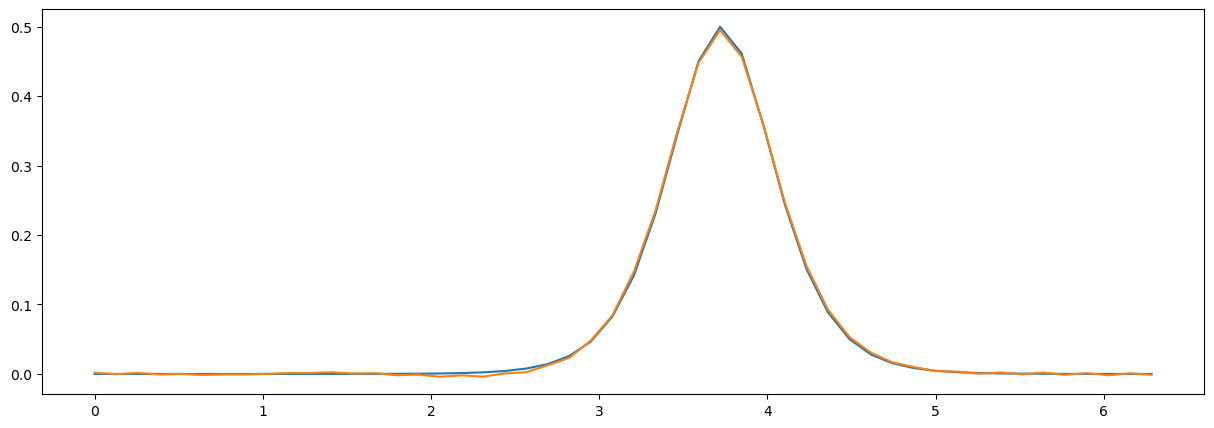

In [150]:
k_select = 200
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.plot(z_2pi, U_full.T[:, k_select]);
ax.plot(z_2pi, U_hat.T[:, k_select]);

In [151]:
# N_max = 100
# N_grid = np.arange(2, N_max, step = 4)
N_grid = np.logspace(1, 2, num = 10, dtype = int)
N_grid += N_grid % 2
print(N_grid)
errors_np_inf = np.zeros(N_grid.shape[0])
errors_l2_norm = np.zeros(N_grid.shape[0])

for i, N in enumerate(tqdm(N_grid)):

    t_tmp, U_hat, z_2pi_tmp = method_of_lines_KdV(N, t0, tf, deriv_const, rtol, atol)

    X_full_ivp, T_full_ivp = np.meshgrid(z_2pi_tmp, t_tmp)
    U_full = u_exact_z(X_full_ivp, T_full_ivp)
    E = U_full - U_hat

    errors_np_inf[i] = np.linalg.norm(E, ord = np.inf)
    errors_l2_norm[i] = np.linalg.norm(E, ord = 'fro')

[ 10  12  16  22  28  36  46  60  78 100]


100%|██████████| 10/10 [00:01<00:00,  7.05it/s]


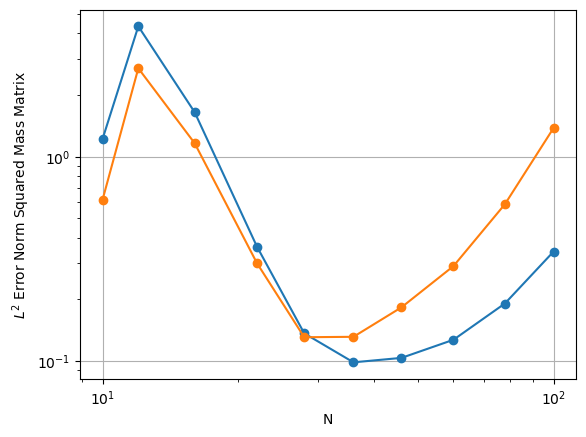

In [152]:
plt.loglog(N_grid, errors_np_inf, 'o-')
plt.loglog(N_grid, errors_l2_norm, 'o-')
plt.grid();
plt.xlabel("N")
plt.ylabel(r"$L^2$ Error Norm Squared Mass Matrix");

## 2h) Advection equation

## Appendix